# Load data

In [2]:
# from datasets import load_dataset
import sys
sys.path.append('../../')
from src.models.continual_training import load_dataset_safe

coin_names = [
    "bitcoin",
    # "litecoin",
    "ethereum",
    # "cardano",
    # "monero",
    "hedera",
    "xrp",
    # "usdt",
    # "usdc",
    "stablecoin",
    "automated market maker",
    " amm ",
    "decentralized exchange",
    "decentralised exchange",
    # "uniswap",
]

hf_datasets = "./../data/hf_datasets"

tweets_ds = load_dataset_safe(hf_datasets, "ExponentialScience/DLT-Tweets")

# tweets_ds = load_dataset(
#     "ExponentialScience/Crypto-Tweets-NER-Sentiment",
#     split="train"
# )


publications_ds = load_dataset_safe(hf_datasets, "ExponentialScience/DLT-Literature")

# publications_ds = load_dataset(
#     "ExponentialScience/DLT-Literature-Final",
#     split="train"
# )

patents_ds = load_dataset_safe(hf_datasets, "ExponentialScience/DLT-Patents")

Count the mentions for specific keywords in the dataset:

In [3]:
# patents_ds = load_dataset(
#     "ExponentialScience/DLT-Patents-NER",
#     split="train"
# )

tweets_ds = tweets_ds.map(
    lambda x: {
        f"contains_{cn}": cn in x["tweet"].lower() for cn in coin_names
    },
    num_proc=8
)

patents_ds = patents_ds.map(
    lambda x: {
        f"contains_{cn}": cn in x["text"].lower() for cn in coin_names
    },
    num_proc=8
)

publications_ds = publications_ds.map(
    lambda x: {
        f"contains_{cn}": cn in x["text"].lower() for cn in coin_names
    },
    num_proc=8
)


def process_year(ds, data_type):
    print(data_type)

    contains_cols = [x for x in ds.features if x.startswith("contains_")]

    if data_type == "tweets":
        ds_cols = ["timestamp", "sentiment_label"]
    elif data_type == "patents":
        ds_cols = ["Date Published"]
    elif data_type == "publications":
        ds_cols = ["year"]

    columns = ds_cols + contains_cols

    if data_type == "tweets":
        columns.append("sentiment_score")

    df = ds.select_columns(columns).to_pandas()

    if data_type in ["tweets", "patents"]:
        df["year"] = df[ds_cols[0]].str.split("-").str[0]
        mask = (df["year"].str.len() == 4) & (df["year"].str[0] == "2")
    elif data_type == "publications":
        mask = df[ds_cols[0]].notna()

    df = df[mask]
    df["year"] = df["year"].astype(int)
    
    return df

tweets_df = process_year(tweets_ds, "tweets")
patents_df = process_year(patents_ds, "patents")
publications_df = process_year(publications_ds, "publications")

tweets
patents
publications


In [9]:
tweets_df.columns

Index(['timestamp', 'sentiment_label', 'contains_bitcoin', 'contains_ethereum',
       'contains_hedera', 'contains_xrp', 'contains_stablecoin',
       'sentiment_score', 'year', 'contains_automated_market_maker',
       'contains_decentralized_exchange'],
      dtype='object')

In [5]:
def aggregate_crypto_columns(df):
    
    # Define aggregation mappings: new_column -> [columns_to_aggregate]
    aggregations = {
        'contains_automated_market_maker': ['contains_automated market maker', 'contains_ amm '],
        'contains_decentralized_exchange': ['contains_decentralised exchange', 'contains_decentralized exchange'],
    }
    
    columns_to_drop = []
    
    # Create aggregated columns
    for new_col, source_cols in aggregations.items():
        # Check which source columns exist in the dataframe
        existing_cols = [col for col in source_cols if col in df.columns]
        
        if existing_cols:
            # Aggregate using logical OR across all existing source columns
            df[new_col] = df[existing_cols].any(axis=1)
            # Mark source columns for removal
            columns_to_drop.extend(existing_cols)
    
    # Drop the original columns that were aggregated
    columns_to_drop = list(set(columns_to_drop))  # Remove duplicates
    df = df.drop(columns=columns_to_drop)
    
    return df

# Aggregate cryptocurrency columns AFTER processing
tweets_df = aggregate_crypto_columns(tweets_df)
patents_df = aggregate_crypto_columns(patents_df)
publications_df = aggregate_crypto_columns(publications_df)

tweets_df.columns

Index(['timestamp', 'sentiment_label', 'contains_bitcoin', 'contains_ethereum',
       'contains_hedera', 'contains_xrp', 'contains_stablecoin',
       'sentiment_score', 'year', 'contains_automated_market_maker',
       'contains_decentralized_exchange'],
      dtype='object')

In [18]:
tweets_df.head().to_csv("./../data/tweets_sample.csv", index=False)

In [22]:
tweets_df_sample = tweets_df.sample(5000, random_state=42)

tweets_df_sample.head()

,timestamp,sentiment_label,contains_bitcoin,contains_litecoin,contains_ethereum,contains_cardano,contains_monero,contains_tether,contains_hedera,contains_hbar,contains_xrpl,contains_xrp,contains_btc,contains_usdt,contains_stablecoin,contains_automated market maker,contains_decentralized exchange,contains_uniswap,sentiment_score,year
14958528,2021-07-10 03:45:02+00:00,bearish,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.920962,2021
9630097,2021-05-17 22:40:45+00:00,bullish,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.811217,2021
6206978,2021-09-07 13:57:17+00:00,neutral,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.507672,2021
18955352,2021-10-14 15:06:49+00:00,bullish,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.866156,2021
15816824,2021-12-17 20:18:28+00:00,bullish,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.426754,2021


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_dataset_stats(df, ds, output_path="./dataset_stats.pdf", show_fewer_years=False):
    sns.set_style("ticks")
    sns.set_context("notebook")

    # Provide standard figure size
    # plt.figure(figsize=(10, 6))
    
    print("Initial dataset size:")
    print(len(ds))
    print("Post cleaning size (after non-clean dates were removed):")
    print(len(df))
    print("Data per year:")
    year_counts = df.groupby("year").size().sort_index()
    print(year_counts)
    
    # Convert to DataFrame for seaborn
    plot_data = year_counts.reset_index()
    plot_data.columns = ['year', 'count']
    
    # Use seaborn barplot
    sns.barplot(data=plot_data, x='year', y='count')
    
    plt.xlabel("")
    plt.ylabel("Number of documents", fontsize=18)

    # Use log scale for y-axis if there are large disparities
    plt.yscale('log')

    # Improve tick labels
    plt.tick_params(axis='both', which='major', labelsize=16)
    
    if show_fewer_years:
    # # Show only every 5 years on x-axis
        years = plot_data['year'].values
        tick_positions = range(0, len(years), 5)
        tick_labels = [years[i] for i in tick_positions]
        plt.xticks(tick_positions, tick_labels, rotation=90)
        # plt.set_xticks(tick_positions)
    
    
    plt.xticks(rotation=90)
    
    # Avoid showing data for every year if too dense
    sns.despine()
    # Tight layout to remove excess whitespace
    plt.tight_layout()
    # Save as high-quality PDF
    plt.savefig(output_path, format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

Initial dataset size:
22047071
Post cleaning size (after non-clean dates were removed):
22033090
Data per year:
year
2013          69
2014        1282
2015        2802
2016        6531
2017       51105
2018      138422
2019      116428
2020      143855
2021    13654861
2022     7707559
2023      210176
dtype: int64


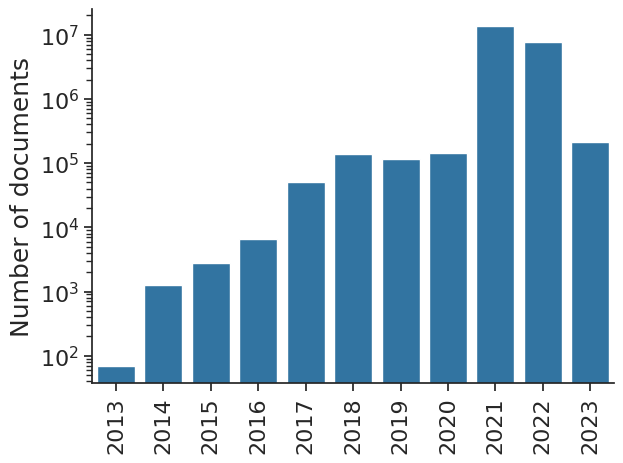

In [31]:
get_dataset_stats(tweets_df, tweets_ds, './../data/tweets_per_year.pdf')

Initial dataset size:
37440
Post cleaning size (after non-clean dates were removed):
37379
Data per year:
year
1978       1
1980       1
1981       2
1982       2
1983       2
1984       3
1985       3
1986       6
1987       7
1988       6
1989      15
1990      25
1991      19
1992      12
1993      19
1994      32
1995      50
1996      71
1997      72
1998      78
1999      78
2000     116
2001     130
2002     188
2003     213
2004     290
2005     389
2006     402
2007     421
2008     427
2009     477
2010     561
2011     658
2012     751
2013     709
2014     915
2015     969
2016     987
2017    1173
2018    1971
2019    3000
2020    3943
2021    4314
2022    6491
2023    6358
2024    1016
2025       6
dtype: int64


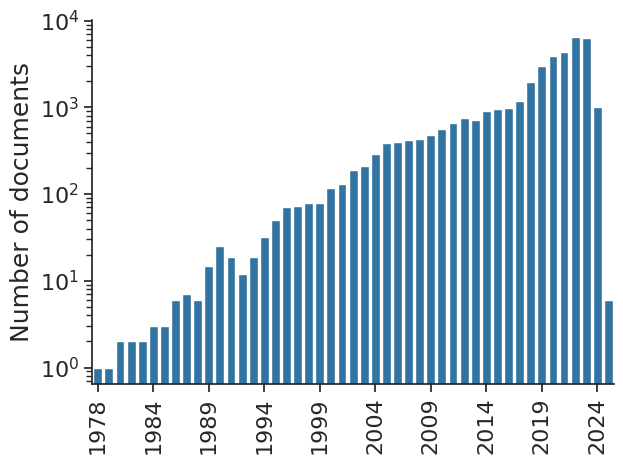

In [37]:
get_dataset_stats(publications_df, publications_ds, './../data/publications_per_year.pdf', show_fewer_years=True)

Initial dataset size:
49023
Post cleaning size (after non-clean dates were removed):
48998
Data per year:
year
2000      33
2001      19
2002      59
2003      59
2004      66
2005      85
2006      94
2007      76
2008      75
2009      64
2010      56
2011      45
2012      50
2013      63
2014      84
2015     120
2016     210
2017     470
2018    1103
2019    2680
2020    5460
2021    6659
2022    7747
2023    8706
2024    9029
2025    5886
dtype: int64


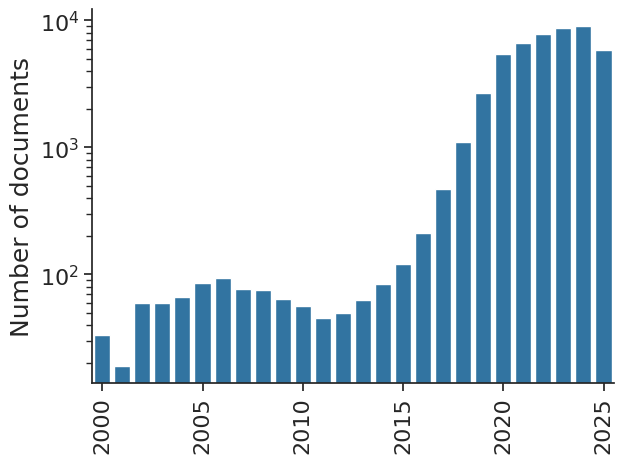

In [35]:
get_dataset_stats(patents_df, patents_ds, './../data/patents_per_year.pdf', show_fewer_years=True)

# Get mentions per year

In [12]:
contains_cols = [x for x in tweets_df.columns if x.startswith("contains")]

In [13]:
sentiment_scores = tweets_df.groupby("year")[["sentiment_label"]].value_counts().reset_index()
# sentiment_scores = tweets_df_sample.groupby("year")[["sentiment_label"]].value_counts().unstack(fill_value=0).reset_index()


# Drop the column sentiment_label
# sentiment_scores.drop(columns=["sentiment_label"], inplace=True)

# Normalize to percentages
sentiment_scores['count'] = sentiment_scores.groupby('year')['count'].transform(lambda x: (x / x.sum()) * 100)

sentiment_scores.head()

,year,sentiment_label,count
0,2013,bullish,49.275362
1,2013,bearish,30.434783
2,2013,neutral,20.289855
3,2014,bullish,54.914197
4,2014,bearish,24.804992


In [14]:
sentiment_scores.to_dict(orient='records')

[{'year': 2013, 'sentiment_label': 'bullish', 'count': 49.275362318840585},
 {'year': 2013, 'sentiment_label': 'bearish', 'count': 30.434782608695656},
 {'year': 2013, 'sentiment_label': 'neutral', 'count': 20.28985507246377},
 {'year': 2014, 'sentiment_label': 'bullish', 'count': 54.91419656786272},
 {'year': 2014, 'sentiment_label': 'bearish', 'count': 24.804992199687987},
 {'year': 2014, 'sentiment_label': 'neutral', 'count': 20.2808112324493},
 {'year': 2015, 'sentiment_label': 'bullish', 'count': 56.174161313347604},
 {'year': 2015, 'sentiment_label': 'bearish', 'count': 24.696645253390432},
 {'year': 2015, 'sentiment_label': 'neutral', 'count': 19.129193433261957},
 {'year': 2016, 'sentiment_label': 'bullish', 'count': 52.50344510794671},
 {'year': 2016, 'sentiment_label': 'bearish', 'count': 24.66697289848415},
 {'year': 2016, 'sentiment_label': 'neutral', 'count': 22.829581993569132},
 {'year': 2017, 'sentiment_label': 'bullish', 'count': 50.20056745915272},
 {'year': 2017, 'se

In [8]:
sent_sample = tweets_df.sample(10).groupby("year")[["sentiment_label"]].value_counts().reset_index()
sent_sample['year'] = sent_sample['year'].astype(int)

# Normalize to percentages
sent_sample['count'] = sent_sample.groupby('year')['count'].transform(lambda x: (x / x.sum()) * 100)

sent_sample

,year,sentiment_label,count
0,2021,bullish,40.0
1,2021,neutral,40.0
2,2021,bearish,20.0
3,2022,bullish,80.0
4,2022,neutral,20.0


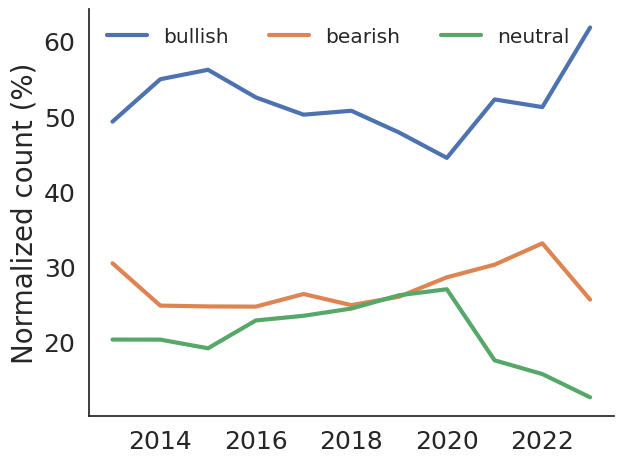

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# sns.set_style("whitegrid")
# sns.set_style("whitegrid")
# sns.set_style("ticks")
# sns.set_context("notebook")

# # Set seaborn style and context
# sns.set_theme(style="whitegrid", 
#               context="notebook", 
#             #   font_scale=1.1
#               )

sns.set_theme(style="white", 
              context="notebook", 
            #   font_scale=1.1
              )

# sentiment_scores

colors = sns.color_palette("muted")

sns.lineplot(data=sentiment_scores, x="year", y="count", hue="sentiment_label", color=colors, linewidth=3)

# # Removes the legend title
# plt.legend(title='', loc='upper left', ncols=3, fontsize=14.5, framealpha=0.9,
#            edgecolor='gray', borderpad=0.6, labelspacing=0.4, frameon=True, fancybox=True)

plt.legend(title='', loc='upper left', ncols=3, fontsize=14.5, frameon=False, fancybox=False)

plt.xlabel("")
plt.ylabel("Normalized count (%)", fontsize=20)

# Log the y-axis if there are large differences in counts
# plt.yscale('log')

# Improve tick labels
plt.tick_params(axis='both', which='major', labelsize=18)
# plt.tick_params(axis='both', which='major', labelsize=10)

# Remove top and right spines for cleaner look
sns.despine()

# Format both axes to show integers only
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()

# plt.savefig('./../data/tweets_sentiment_per_year.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

In [35]:
tweet_scores = tweets_df.groupby("year")[contains_cols].mean()
patents_scores = patents_df.groupby("year")[contains_cols].mean()
publications_scores = publications_df.groupby("year")[contains_cols].mean()

Bitcoin mentions over time


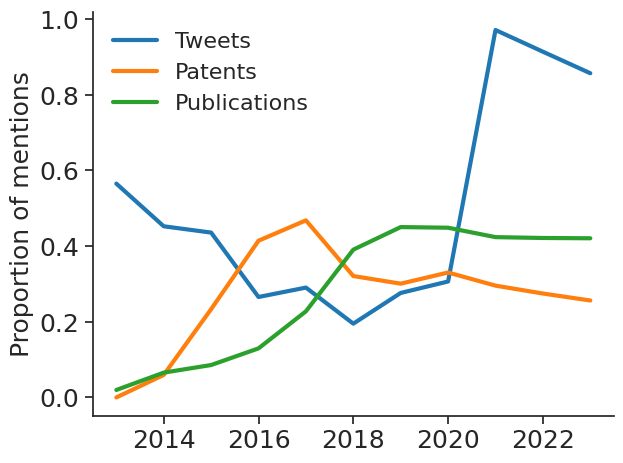

Ethereum mentions over time


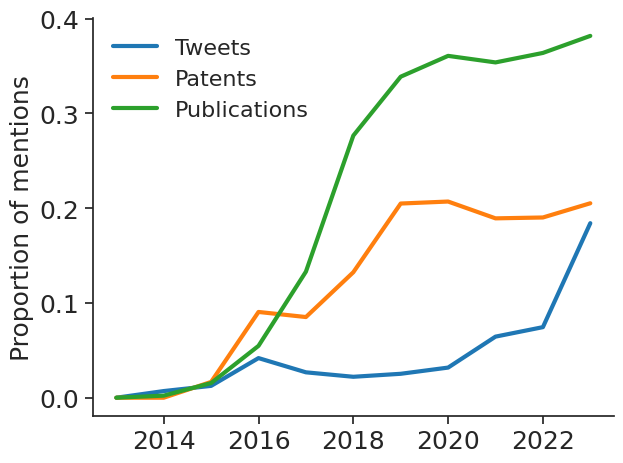

Hedera mentions over time


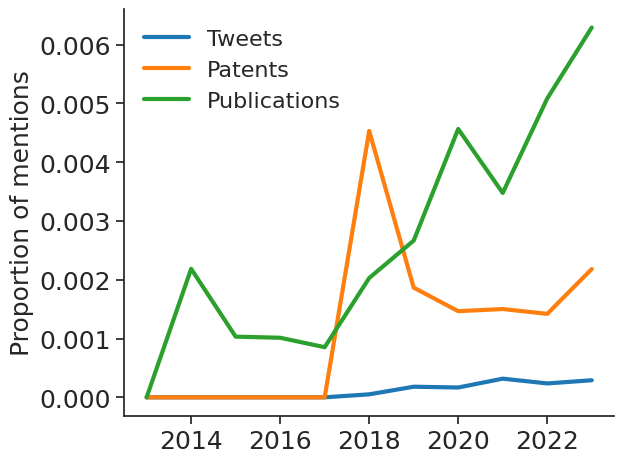

Xrp mentions over time


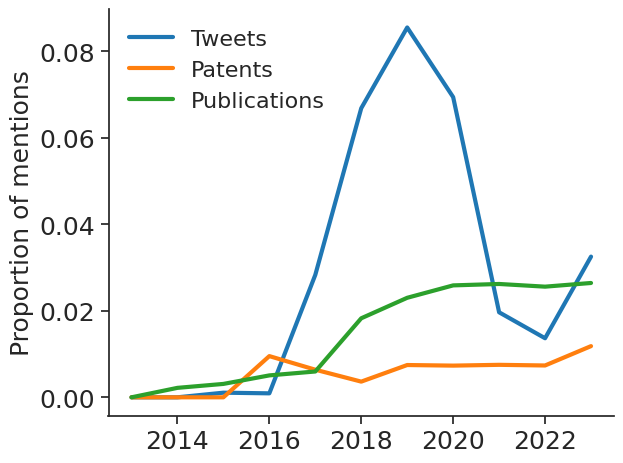

Usdt mentions over time


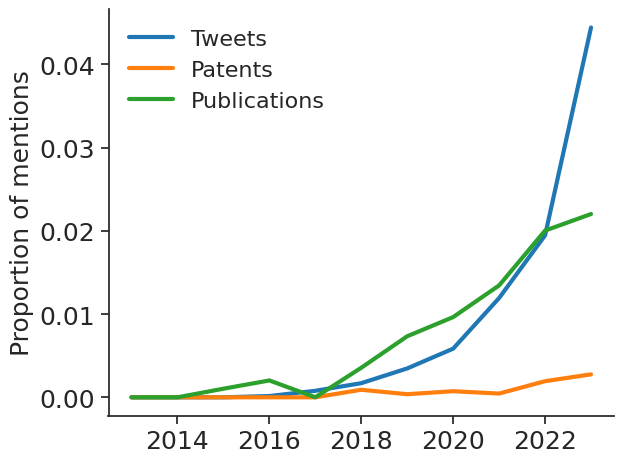

Usdc mentions over time


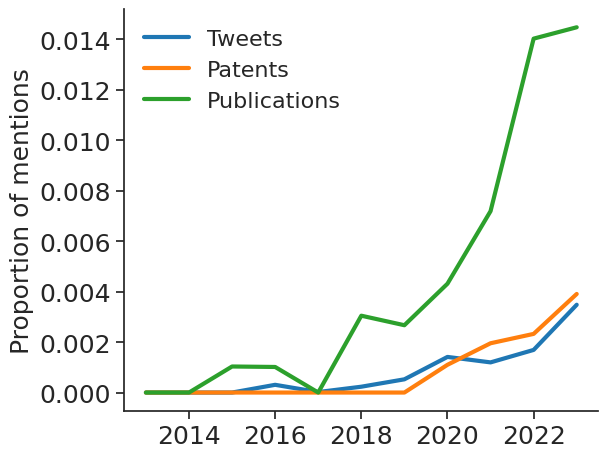

Stablecoin mentions over time


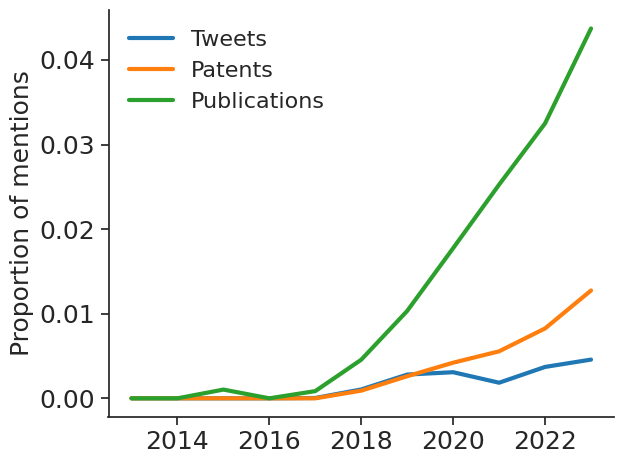

Automated mentions over time


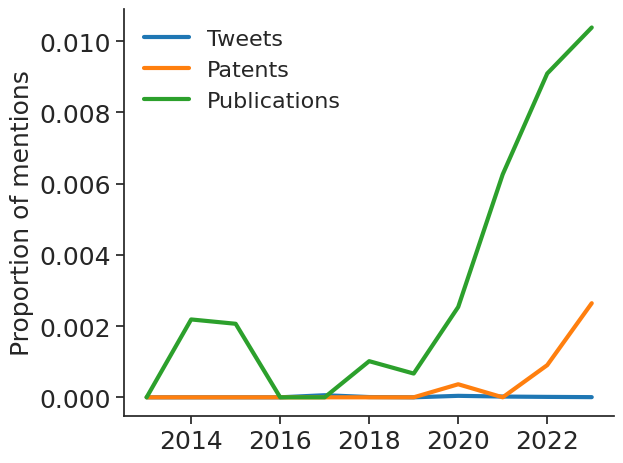

Decentralized mentions over time


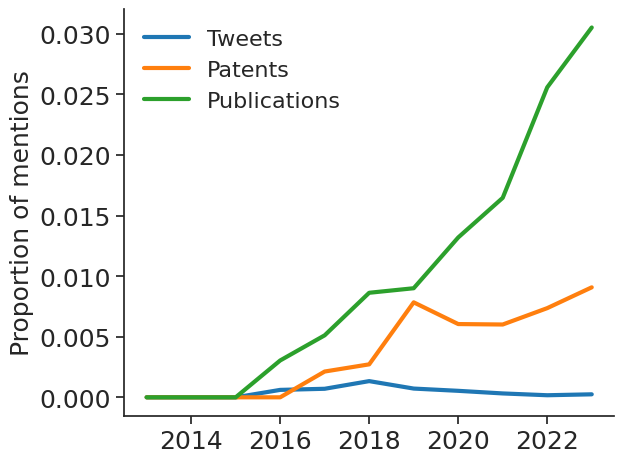

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks")
sns.set_context("notebook")

# # Set seaborn style and context
# sns.set_theme(style="whitegrid", context="notebook", 
#             #   font_scale=1.1
#               )

for col in tweet_scores.columns:
    conjoin_years = sorted(list(set(tweet_scores[col].index) & set(patents_scores[col].index) & set(publications_scores[col].index)))

    ax = tweet_scores[col].loc[conjoin_years].plot(linewidth=3)
    ax = patents_scores[col].loc[conjoin_years].plot(ax=ax, linewidth=3)
    publications_scores[col].loc[conjoin_years].plot(ax=ax, linewidth=3)

    col_val = col.split("_")[1]
    # ax.set_title(f"{col_val.capitalize()} mentions over time")
    # ax.set_xlabel("Year")
    ax.set_xlabel("")
    ax.set_ylabel("Proportion of mentions", fontsize=18)
    # ax.legend(["Tweets", "Patents", "Publications"], frameon=False, loc='upper left', fontsize=16)

    ax.legend(["Social Media", "Patents", "Scientific Lit."], frameon=False, loc='upper left', fontsize=16)


    # # Force x-axis to show up to 2025
    # ax.set_xlim(right=2025)

    # Ticks font size
    plt.tick_params(axis='both', which='major', labelsize=18)
    
    # Remove top and right spines for cleaner look
    sns.despine()

    plt.tight_layout()

    print(f"{col_val.capitalize()} mentions over time")

    plt.savefig(f'./../data/{col_val.replace(" ", "_")}_mentions_per_year.pdf', format='pdf', bbox_inches='tight', dpi=300)

    plt.show()

✓ Saved: bitcoin_mentions_per_year.pdf
  Scientific Lit. starts: 2013
  Patents starts: 2014
  Social Media starts: 2013



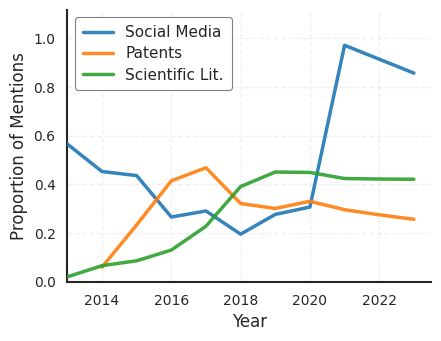

✓ Saved: ethereum_mentions_per_year.pdf
  Scientific Lit. starts: 2014
  Patents starts: 2015
  Social Media starts: 2014



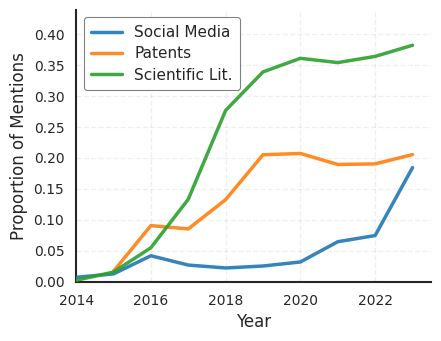

✓ Saved: hedera_mentions_per_year.pdf
  Scientific Lit. starts: 2014
  Patents starts: 2018
  Social Media starts: 2019



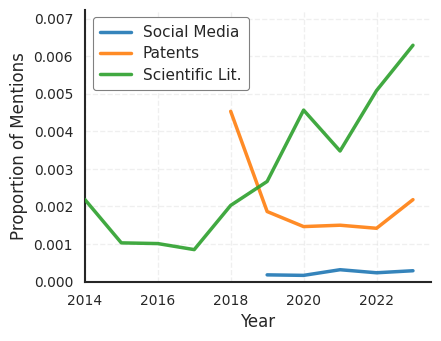

✓ Saved: xrp_mentions_per_year.pdf
  Scientific Lit. starts: 2014
  Patents starts: 2016
  Social Media starts: 2015



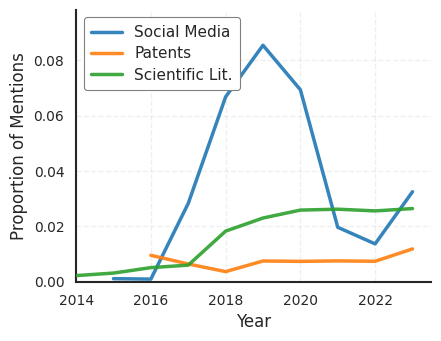

✓ Saved: stablecoin_mentions_per_year.pdf
  Scientific Lit. starts: 2015
  Patents starts: 2018
  Social Media starts: 2018



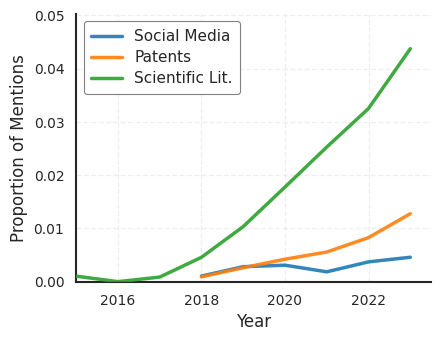

✓ Saved: automated_mentions_per_year.pdf
  Scientific Lit. starts: 2014
  Patents starts: 2020
  Social Media starts: 2020



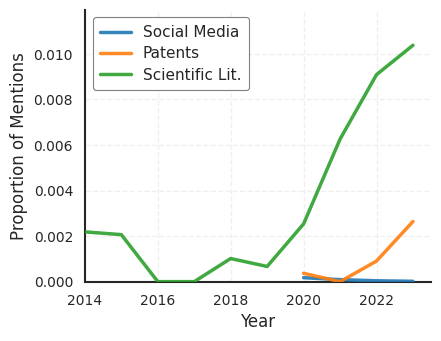

✓ Saved: decentralized_mentions_per_year.pdf
  Scientific Lit. starts: 2016
  Patents starts: 2017
  Social Media starts: 2016



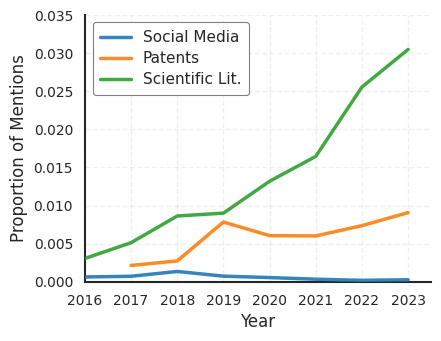

✓ All mention plots created successfully!


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style for academic publications
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5

sns.set_theme(style="white", context="paper")

colors = sns.color_palette("tab10", 3)

# Color palette - consistent with other plots
colors = {
    'Social Media': colors[0],    # Orange
    'Patents': colors[1],          # Purple
    'Scientific Lit.': colors[2]   # Blue
}

def filter_from_first_nonzero(series, threshold=0.0001):
    # Find indices where values are above threshold
    non_zero_mask = series > threshold
    
    if non_zero_mask.any():
        # Get the first index where value is non-zero
        first_nonzero_idx = series[non_zero_mask].index[0]
        # Return series from that point onwards
        return series[series.index >= first_nonzero_idx]
    else:
        # If all zeros, return empty series
        return pd.Series(dtype=float)

def plot_mentions_professional(tweet_scores, patents_scores, publications_scores, 
                                col, save_dir='./../data/'):
    
    # Get conjoin years
    conjoin_years = sorted(list(
        set(tweet_scores[col].index) & 
        set(patents_scores[col].index) & 
        set(publications_scores[col].index)
    ))
    
    # Extract data
    social_data = tweet_scores[col].loc[conjoin_years]
    patents_data = patents_scores[col].loc[conjoin_years]
    pubs_data = publications_scores[col].loc[conjoin_years]
    
    # Replace any negative values with 0
    social_data = social_data.clip(lower=0)
    patents_data = patents_data.clip(lower=0)
    pubs_data = pubs_data.clip(lower=0)
    
    # Filter each series to start from first non-zero value
    social_filtered = filter_from_first_nonzero(social_data)
    patents_filtered = filter_from_first_nonzero(patents_data)
    pubs_filtered = filter_from_first_nonzero(pubs_data)

    # Get the minimum starting year among the three filtered series
    start_year = min([min(social_filtered.index), min(patents_filtered.index), min(pubs_filtered.index)])
    
    # Create figure
    fig, ax = plt.subplots(figsize=(4.5, 3.5))
    
    # Plot lines (only from first non-zero value)
    if len(social_filtered) > 0:
        ax.plot(social_filtered.index, social_filtered.values,
                color=colors['Social Media'],
                linewidth=2.5,
                label='Social Media',
                alpha=0.9,
                zorder=3)
    
    if len(patents_filtered) > 0:
        ax.plot(patents_filtered.index, patents_filtered.values,
                color=colors['Patents'],
                linewidth=2.5,
                label='Patents',
                alpha=0.9,
                zorder=3)
    
    if len(pubs_filtered) > 0:
        ax.plot(pubs_filtered.index, pubs_filtered.values,
                color=colors['Scientific Lit.'],
                linewidth=2.5,
                label='Scientific Lit.',
                alpha=0.9,
                zorder=3)
    
    # Extract and format term name
    col_val = col.split("_")[1] if "_" in col else col
    
    # Labels and title
    ax.set_xlabel('Year', fontsize=12, 
                #   fontweight='bold'
                  )
    ax.set_ylabel('Proportion of Mentions', 
                  fontsize=12, 
                #   fontweight='bold'
                  )
    # ax.set_title(f'{col_val.capitalize()} Mentions Over Time',
    #              fontsize=12, fontweight='bold', pad=12, loc='left')

    ax.set_title(f'',
                fontsize=12, fontweight='bold', pad=12, loc='left')
    
    # Legend
    legend = ax.legend(loc='upper left',
                       frameon=True,
                       fancybox=True,
                       shadow=False,
                       fontsize=11,
                       framealpha=1.0,
                       edgecolor='gray',
                       borderpad=0.5,
                       labelspacing=0.4)
    legend.set_zorder(100)
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.grid(alpha=0.3, linestyle='--', linewidth=1, zorder=0)
    ax.set_axisbelow(True)
    ax.tick_params(width=1.5, length=5, labelsize=10)
    
    # Set y-axis limits starting from 0
    all_values = []
    if len(social_filtered) > 0:
        all_values.extend(social_filtered.values)
    if len(patents_filtered) > 0:
        all_values.extend(patents_filtered.values)
    if len(pubs_filtered) > 0:
        all_values.extend(pubs_filtered.values)
    
    if len(all_values) > 0:
        y_max = max(all_values)
        ax.set_ylim(0, y_max * 1.15)
    else:
        ax.set_ylim(0, 1)
    
    # Set x-axis limits based on the full range of conjoin_years
    # if len(conjoin_years) > 0:
    #     ax.set_xlim(min(conjoin_years) - 0.5, max(conjoin_years) + 0.5)

    # Set x-axis limits based on the minimum starting year
    if start_year:
        ax.set_xlim(start_year, max(conjoin_years) + 0.5)
    
    plt.tight_layout()
    
    # Save
    filename = f'{col_val.replace(" ", "_").lower()}_mentions_per_year.pdf'
    plt.savefig(f'{save_dir}{filename}', format='pdf', bbox_inches='tight', dpi=300)
    
    print(f"✓ Saved: {filename}")
    
    # Print first appearances for reference
    if len(pubs_filtered) > 0:
        print(f"  Scientific Lit. starts: {int(pubs_filtered.index[0])}")
    if len(patents_filtered) > 0:
        print(f"  Patents starts: {int(patents_filtered.index[0])}")
    if len(social_filtered) > 0:
        print(f"  Social Media starts: {int(social_filtered.index[0])}")
    print()
    
    plt.show()
    plt.close()

for col in tweet_scores.columns:
    plot_mentions_professional(tweet_scores, patents_scores, publications_scores, col)

print("✓ All mention plots created successfully!")

# Crypto Market Capitalization

In [2]:
import pandas as pd

df_mktcap = pd.read_csv('./../data/CoinGecko-GlobalCryptoMktCap-2025-10-06.csv')

df_mktcap.head()

,snapped_at,market_cap,total_volume
0,1367193600000,1.661442e+09,0.0
1,1367280000000,1.592765e+09,0.0
2,1367366400000,1.378705e+09,0.0
3,1367452800000,1.220763e+09,0.0
4,1367539200000,1.075224e+09,0.0


In [3]:
# Convert unix timestamp to datetime
df_mktcap['timestamp'] = pd.to_datetime(df_mktcap['snapped_at'], unit='ms')

# Agregate by median market cap per year
df_mktcap['year'] = df_mktcap['timestamp'].dt.year
df_mktcap = df_mktcap.groupby('year')['market_cap'].median().reset_index()

# Calculate in billions
df_mktcap['market_cap'] = df_mktcap['market_cap'] / 1e9

df_mktcap.head()

,year,market_cap
0,2013,1.582489
1,2014,7.367598
2,2015,4.155375
3,2016,11.556311
4,2017,99.140094


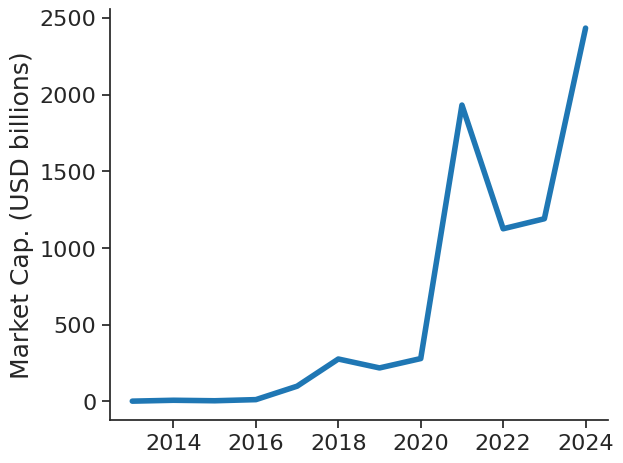

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

sns.set_style("ticks")
sns.set_context("notebook")

# plt.figure(figsize=(10, 6))

sns.lineplot(data=df_mktcap, x="year", y="market_cap", linewidth=4)

# Improve tick labels
plt.tick_params(axis='both', which='major', labelsize=16)

plt.xlabel("")
plt.ylabel("Market Cap. (USD billions)", fontsize=18)

# Format both axes to show integers only
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Remove top and right spines for cleaner look
sns.despine()

plt.tight_layout()

plt.savefig(f'./../data/crypto_market_capitalization_per_year.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

plt.close()

## Correlation analysis of Market Cap and Patents, Literature and Posts activity

In [4]:
import scipy.stats as stats
import numpy as np

# Filter out from 2013 onwards
tweets_df = tweets_ds.select_columns(["timestamp"]).to_pandas()
patents_df = patents_ds.select_columns(["Date Published"]).to_pandas()
publications_df = publications_ds.select_columns(["year", "title", "url", "paperId"]).to_pandas()

Get the yearly publications and posts counts:

In [5]:
tweets_df['year'] = tweets_df['timestamp'].str.split("-").str[0]
patents_df['year'] = patents_df['Date Published'].str.split("-").str[0]

In [6]:
# Get the counts per year
tweets_counts = tweets_df['year'].value_counts().sort_index()
patents_counts = patents_df['year'].value_counts().sort_index()
publications_counts = publications_df['year'].value_counts().sort_index()

In [7]:
# Remove wrong values from tweets
tweets_counts = tweets_counts[tweets_counts.index.str.len() == 4]
tweets_counts.head()

year
2013       69
2014     1282
2015     2802
2016     6531
2017    51105
Name: count, dtype: int64

In [12]:
tweets_counts.reset_index().to_dict(orient='records')

[{'year': '2013', 'count': 69},
 {'year': '2014', 'count': 1282},
 {'year': '2015', 'count': 2802},
 {'year': '2016', 'count': 6531},
 {'year': '2017', 'count': 51105},
 {'year': '2018', 'count': 138422},
 {'year': '2019', 'count': 116428},
 {'year': '2020', 'count': 143855},
 {'year': '2021', 'count': 13654861},
 {'year': '2022', 'count': 7707559},
 {'year': '2023', 'count': 210176}]

In [13]:
publications_counts.reset_index().to_dict(orient='records')

[{'year': 1978.0, 'count': 1},
 {'year': 1980.0, 'count': 1},
 {'year': 1981.0, 'count': 2},
 {'year': 1982.0, 'count': 2},
 {'year': 1983.0, 'count': 2},
 {'year': 1984.0, 'count': 3},
 {'year': 1985.0, 'count': 3},
 {'year': 1986.0, 'count': 6},
 {'year': 1987.0, 'count': 7},
 {'year': 1988.0, 'count': 6},
 {'year': 1989.0, 'count': 15},
 {'year': 1990.0, 'count': 25},
 {'year': 1991.0, 'count': 19},
 {'year': 1992.0, 'count': 12},
 {'year': 1993.0, 'count': 19},
 {'year': 1994.0, 'count': 32},
 {'year': 1995.0, 'count': 50},
 {'year': 1996.0, 'count': 71},
 {'year': 1997.0, 'count': 72},
 {'year': 1998.0, 'count': 78},
 {'year': 1999.0, 'count': 78},
 {'year': 2000.0, 'count': 116},
 {'year': 2001.0, 'count': 130},
 {'year': 2002.0, 'count': 188},
 {'year': 2003.0, 'count': 213},
 {'year': 2004.0, 'count': 290},
 {'year': 2005.0, 'count': 389},
 {'year': 2006.0, 'count': 402},
 {'year': 2007.0, 'count': 421},
 {'year': 2008.0, 'count': 427},
 {'year': 2009.0, 'count': 477},
 {'year'

In [14]:
patents_counts.reset_index().to_dict(orient='records')

[{'year': '1990', 'count': 1},
 {'year': '1993', 'count': 1},
 {'year': '1994', 'count': 1},
 {'year': '1995', 'count': 1},
 {'year': '1996', 'count': 4},
 {'year': '1997', 'count': 2},
 {'year': '1998', 'count': 4},
 {'year': '1999', 'count': 11},
 {'year': '2000', 'count': 33},
 {'year': '2001', 'count': 19},
 {'year': '2002', 'count': 59},
 {'year': '2003', 'count': 59},
 {'year': '2004', 'count': 66},
 {'year': '2005', 'count': 85},
 {'year': '2006', 'count': 94},
 {'year': '2007', 'count': 76},
 {'year': '2008', 'count': 75},
 {'year': '2009', 'count': 64},
 {'year': '2010', 'count': 56},
 {'year': '2011', 'count': 45},
 {'year': '2012', 'count': 50},
 {'year': '2013', 'count': 63},
 {'year': '2014', 'count': 84},
 {'year': '2015', 'count': 120},
 {'year': '2016', 'count': 210},
 {'year': '2017', 'count': 470},
 {'year': '2018', 'count': 1103},
 {'year': '2019', 'count': 2680},
 {'year': '2020', 'count': 5460},
 {'year': '2021', 'count': 6659},
 {'year': '2022', 'count': 7747},
 {

In [15]:
df_mktcap.to_dict(orient='records')

[{'year': 2013, 'market_cap': 1.582489464},
 {'year': 2014, 'market_cap': 7.3675975685},
 {'year': 2015, 'market_cap': 4.155374921644521},
 {'year': 2016, 'market_cap': 11.556311140148864},
 {'year': 2017, 'market_cap': 99.14009432528798},
 {'year': 2018, 'market_cap': 276.2620426132273},
 {'year': 2019, 'market_cap': 218.1713293336849},
 {'year': 2020, 'market_cap': 279.2041636383777},
 {'year': 2021, 'market_cap': 1931.4128126413036},
 {'year': 2022, 'market_cap': 1125.2007077254812},
 {'year': 2023, 'market_cap': 1190.4747082768013},
 {'year': 2024, 'market_cap': 2433.0152163794373},
 {'year': 2025, 'market_cap': 3450.658242625493}]

Total publications and papents before 2013 when Market Capitalization starts being tracked by CoinGecko:

In [27]:
print(f"Total publications before 2013: {publications_counts[publications_counts.index.astype(int) < 2013].sum()}")
print(f"Total patents before 2013: {patents_counts[patents_counts.index.astype(int) < 2013].sum()}")

Total publications before 2013: 5527
Total patents before 2013: 806


Filter out to use the similar starting year as the market capitalization dataset:

In [31]:
start_year = df_mktcap['year'].min()
print(f"Start year for market cap data collected by CoinGecko: {start_year}")

Start year for market cap data collected by CoinGecko: 2013


In [32]:
publications_counts = publications_counts[publications_counts.index.astype(int) >= start_year]
tweets_counts = tweets_counts[tweets_counts.index.astype(int) >= start_year]
patents_counts = patents_counts[patents_counts.index.astype(int) >= start_year]

Filter for all content before 2025, including market capitalization data:

In [33]:
end_year = 2024

publications_counts = publications_counts[publications_counts.index.astype(int) <= end_year]
tweets_counts = tweets_counts[tweets_counts.index.astype(int) <= end_year]
patents_counts = patents_counts[patents_counts.index.astype(int) <= end_year]
df_mktcap = df_mktcap[df_mktcap['year'] <= end_year]

In [34]:
# Calculate spearman correlation for publications and market cap
spearman_rank, p_value = stats.spearmanr(publications_counts.sort_index().values, df_mktcap.set_index('year').loc[publications_counts.index.astype(int), 'market_cap'].values)

In [35]:
df_mktcap.set_index('year').loc[publications_counts.index.astype(int), 'market_cap'].values

array([1.58248946e+00, 7.36759757e+00, 4.15537492e+00, 1.15563111e+01,
       9.91400943e+01, 2.76262043e+02, 2.18171329e+02, 2.79204164e+02,
       1.93141281e+03, 1.12520071e+03, 1.19047471e+03, 2.43301522e+03])

In [36]:
spearman_rank, p_value

(np.float64(0.7622377622377624), np.float64(0.003950448972542651))

In [37]:
# Calculate spearman correlation for patents and market cap
spearman_rank, p_value = stats.spearmanr(patents_counts.sort_index().values, df_mktcap.set_index('year').loc[patents_counts.index.astype(int), 'market_cap'].values)

In [38]:
spearman_rank, p_value

(np.float64(0.965034965034965), np.float64(3.88098529962746e-07))

In [39]:
# Calculate spearman correlation for tweets and market cap
spearman_rank, p_value = stats.spearmanr(tweets_counts.sort_index().values, df_mktcap.set_index('year').loc[tweets_counts.index.astype(int), 'market_cap'].values)

In [40]:
spearman_rank, p_value

(np.float64(0.9818181818181818), np.float64(8.403066433955246e-08))

### Lags correlation of Scientific Publications and Market Capitalization

In [50]:
## Lags correlation of Scientific Publications and Market Capitalization
import matplotlib.pyplot as plt
import seaborn as sns

# max_lag = 5
# lags = range(-max_lag, max_lag + 1)
# correlations = []
# p_values = []

# for lag in lags:
#     if lag < 0:
#         shifted_publications = publications_counts.sort_index().values[:lag]
#         aligned_market_cap = df_mktcap.set_index('year').loc[publications_counts.index.astype(int), 'market_cap'].values[-lag:]
#     elif lag > 0:
#         shifted_publications = publications_counts.sort_index().values[lag:]
#         aligned_market_cap = df_mktcap.set_index('year').loc[publications_counts.index.astype(int), 'market_cap'].values[:-lag]
#     else:
#         shifted_publications = publications_counts.sort_index().values
#         aligned_market_cap = df_mktcap.set_index('year').loc[publications_counts.index.astype(int), 'market_cap'].values

#     spearman_rank, p_value = stats.spearmanr(shifted_publications, aligned_market_cap)
#     correlations.append(spearman_rank)
#     p_values.append(p_value)


def calculate_lagged_correlation(documents, market_cap, max_lag):
    lags = range(-max_lag, max_lag + 1)
    correlations = []
    p_values = []

    for lag in lags:
        if lag < 0:
            shifted_docs = documents.sort_index().values[:lag]
            aligned_market_cap = market_cap.set_index('year').loc[documents.index.astype(int), 'market_cap'].values[-lag:]
        elif lag > 0:
            shifted_docs = documents.sort_index().values[lag:]
            aligned_market_cap = market_cap.set_index('year').loc[documents.index.astype(int), 'market_cap'].values[:-lag]
        else:
            shifted_docs = documents.sort_index().values
            aligned_market_cap = market_cap.set_index('year').loc[documents.index.astype(int), 'market_cap'].values

        spearman_rank, p_value = stats.spearmanr(shifted_docs, aligned_market_cap)
        correlations.append(spearman_rank)
        p_values.append(p_value)

    df_lag_corr = pd.DataFrame({
    'lag': lags,
    'spearman_correlation': correlations,
    'p_value': p_values
    })
    
    
    return df_lag_corr

In [52]:
def plot_lagged_correlation(df_lag_corr):

    sns.set_style("ticks")
    sns.set_context("notebook")
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_lag_corr, x="lag", y='spearman_correlation', marker='o', linewidth=3)
    plt.xlabel("Lag (years)", fontsize=18)
    plt.ylabel("Spearman Correlation", fontsize=18)
    # plt.xticks(lags)
    plt.tick_params(axis='both', which='major', labelsize=16)
    sns.despine()
    plt.tight_layout()
    # plt.savefig('./../data/publications_market_cap_lag_correlation.pdf', format='pdf',
    #             bbox_inches='tight', dpi=300)
    plt.show()

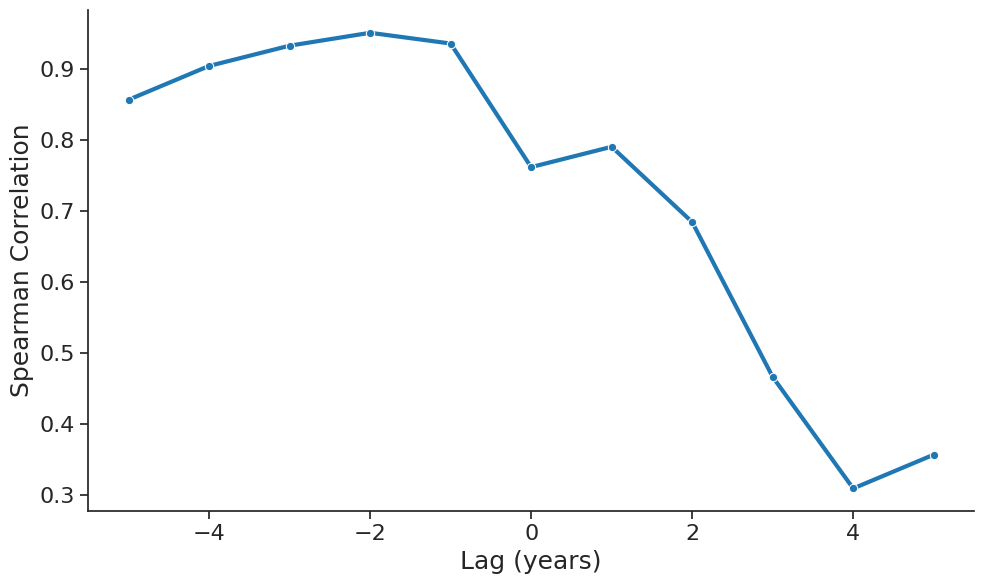

In [53]:
scientific_publications_lag_corr = calculate_lagged_correlation(publications_counts, df_mktcap, max_lag=5)
plot_lagged_correlation(scientific_publications_lag_corr)

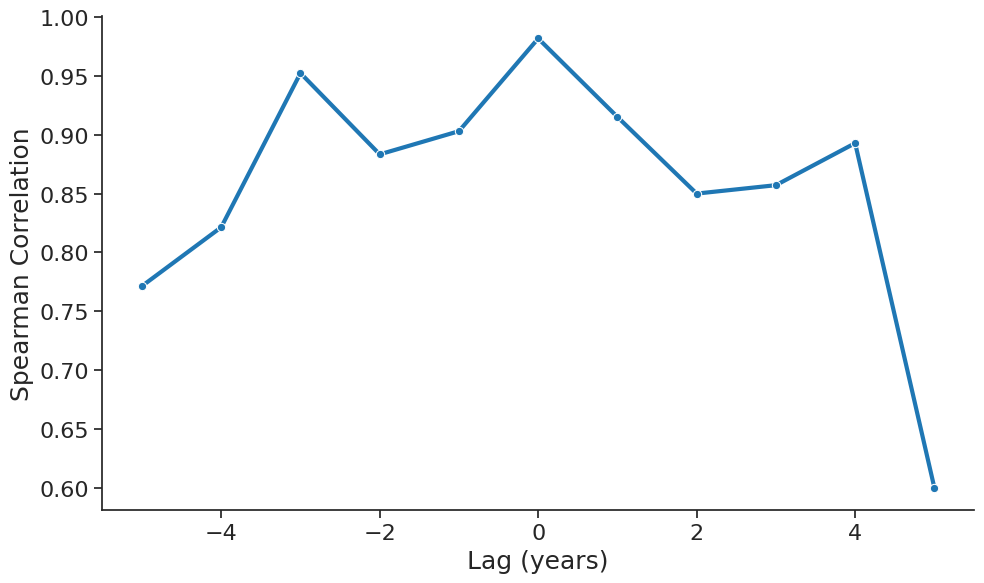

In [54]:
tweets_lag_corr = calculate_lagged_correlation(tweets_counts, df_mktcap, max_lag=5)
plot_lagged_correlation(tweets_lag_corr)

In [60]:
tweets_lag_corr

,lag,spearman_correlation,p_value
0,-5,0.771429,7.239650e-02
1,-4,0.821429,2.344881e-02
2,-3,0.952381,2.604000e-04
3,-2,0.883333,1.590500e-03
4,-1,0.903030,3.436122e-04
5,0,0.981818,8.403066e-08
6,1,0.915152,2.044724e-04
7,2,0.850000,3.704777e-03
8,3,0.857143,6.530017e-03
9,4,0.892857,6.807187e-03


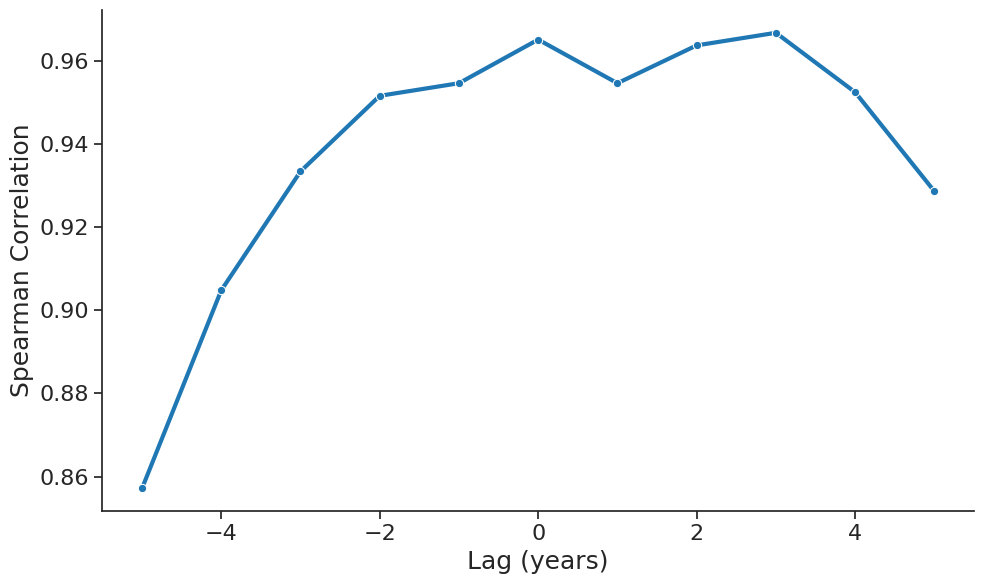

In [55]:
patents_lag_corr = calculate_lagged_correlation(patents_counts, df_mktcap, max_lag=5)
plot_lagged_correlation(patents_lag_corr)

In [61]:
patents_lag_corr

,lag,spearman_correlation,p_value
0,-5,0.857143,1.369733e-02
1,-4,0.904762,2.008276e-03
2,-3,0.933333,2.358998e-04
3,-2,0.951515,2.279855e-05
4,-1,0.954545,4.988899e-06
5,0,0.965035,3.880985e-07
6,1,0.954545,4.988899e-06
7,2,0.963636,7.320975e-06
8,3,0.966667,2.155031e-05
9,4,0.952381,2.604000e-04


In [58]:
patents_lag_corr.to_dict(orient='records')

[{'lag': -5,
  'spearman_correlation': 0.8571428571428573,
  'p_value': 0.01369732661532562},
 {'lag': -4,
  'spearman_correlation': 0.9047619047619048,
  'p_value': 0.0020082755054294677},
 {'lag': -3,
  'spearman_correlation': 0.9333333333333332,
  'p_value': 0.00023589981215941676},
 {'lag': -2,
  'spearman_correlation': 0.9515151515151514,
  'p_value': 2.279854920641689e-05},
 {'lag': -1,
  'spearman_correlation': 0.9545454545454546,
  'p_value': 4.988898739949763e-06},
 {'lag': 0,
  'spearman_correlation': 0.965034965034965,
  'p_value': 3.88098529962746e-07},
 {'lag': 1,
  'spearman_correlation': 0.9545454545454546,
  'p_value': 4.988898739949763e-06},
 {'lag': 2,
  'spearman_correlation': 0.9636363636363635,
  'p_value': 7.320974809529922e-06},
 {'lag': 3,
  'spearman_correlation': 0.9666666666666667,
  'p_value': 2.155031274835775e-05},
 {'lag': 4,
  'spearman_correlation': 0.9523809523809524,
  'p_value': 0.00026040002438725105},
 {'lag': 5,
  'spearman_correlation': 0.9285714

In [59]:
tweets_lag_corr.to_dict(orient='records')

[{'lag': -5,
  'spearman_correlation': 0.7714285714285715,
  'p_value': 0.07239650145772594},
 {'lag': -4,
  'spearman_correlation': 0.8214285714285715,
  'p_value': 0.023448808345691505},
 {'lag': -3,
  'spearman_correlation': 0.9523809523809524,
  'p_value': 0.00026040002438725105},
 {'lag': -2,
  'spearman_correlation': 0.8833333333333333,
  'p_value': 0.0015905004234978686},
 {'lag': -1,
  'spearman_correlation': 0.9030303030303028,
  'p_value': 0.00034361219776328223},
 {'lag': 0,
  'spearman_correlation': 0.9818181818181818,
  'p_value': 8.403066433955246e-08},
 {'lag': 1,
  'spearman_correlation': 0.9151515151515152,
  'p_value': 0.0002044724061488323},
 {'lag': 2,
  'spearman_correlation': 0.8499999999999999,
  'p_value': 0.0037047773275858133},
 {'lag': 3,
  'spearman_correlation': 0.8571428571428572,
  'p_value': 0.006530017254715292},
 {'lag': 4,
  'spearman_correlation': 0.8928571428571429,
  'p_value': 0.006807187408935392},
 {'lag': 5, 'spearman_correlation': 0.6, 'p_valu